In [1]:
import torch 
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from utils import make_from_file, retrieve_setup


/home/admin/miniconda3/envs/oml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train(X_batch, y_batch, model, optimizer, loss_fn):
    """
    Train one iteration.

    Parameters:
    ----------
    X_batch: pytorch.Tensor
        Batch of data.

    y_batch: pytorch.Tensor
        Labels of data.

    model: pytorch.Model
        Model.

    optimizer: pytorch.Optimizer
        Optimizer.

    loss_fn: pytorch.Functional 
        Loss function. 

    Returns:
    -------
    loss: float
        Loss.
    """
    model.train()
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def eval():
    pass

def update_log(dataset, model, strategy, iter, epoch):

    if strategy[0] == "iter":
        if iter % strategy[1] == 0:
            pass
            # compute metrics (e.g. metrics = eval(dataset, model))
            # add metrics to the log
        
    if strategy[0] == "epoch":
        # retrieve last epoch
        last_epoch = ...
        if epoch % strategy[1] == 0 and last_epoch != epoch:
            pass 
            # compute metrics (e.g. metrics = eval(dataset, model))
            # add metrics to the log


def training_loop(model, dataset, scheduler, from_file=None, optimizer=None, loss_fn=None, 
          n_epochs=None, batch_size=None, train_strategy=("", 1), test_strategy=("", 1),
          scheduler_strategy="iter", device=None):
    """
    Train model over multiple epochs.

    Parameters:
    ----------
    model: pytorch.Model
        Model.
    
    dataset: dict
        Dataset:
            "train": pytorch.Dataset
                Training data.
            "test": pytorch.Dataset
                Test data.

    scheduler: pytorch.Scheduler
        Scheduler.

    from_file: path-like
        Path to parameter file (.yml). If a function parameter is None,
        then it will be set to the default value given by the file.

    optimizer: pytorch.Optimizer
        Optimizer.

    loss_fn: pytorch.Functional
        Loss function.

    n_epochs: int
        Number of epochs.

    batch_size: int
        Number of samples per batch.

    train_strategy: tuple(str, int)
        Strategy to evaluate training data. The first elment should be 
        a string ('iter' or 'epoch') indicating wether the evaluation 
        should be done per iteration or per epoch. The second element
        should be an integer indicating how many iteration or epochs 
        to wait between each evaluation.

    test_strategy: tuple(str, int)
        Strategy to evaluate test data. See train_strategy.

    scheduler_strategy: str
        Scheduler strategy, either 'iter' or 'epoch. Indicates if the 
        scheduler should be updated each epoch or each iteration.

    device: str
        Device ('cpu' or 'gpu') on which to run the model.
    """

    if device == "gpu":
        assert torch.cuda.is_available(), "No GPU access :("

    # default options
    if from_file is not None:
        dataset_name = dataset["train"].root.split("/")[-1]
        o, l, e, b = make_from_file(from_file, model, dataset_name)

    if optimizer is None:
        optimizer = o 
    if loss_fn is None:
        loss_fn = l 
    if n_epochs is None:
        n_epochs = e 
    if batch_size is None:
        batch_size = b

    # data loader
    data_loader = torch.utils.data.DataLoader(dataset["train"], batch_size, shuffle=True)

    # storage
    losses = []

    # training
    model.to(device)
    iter = 0
    for epoch in range(n_epochs):
        for X_batch, y_batch in data_loader:
            iter += 1
            X_batch.to(device)

            # train with batch
            loss = train(X_batch, y_batch, model, optimizer, loss_fn)
            losses.append(loss)

            # update Tensorboard
            # update_log(dataset["train"], model, training_strategy, iter, epoch)  # add scheduler ?
            # update_log(data["test"], model, eval_strategy, iter, epoch)

            # update scheduler
            if scheduler_strategy == "iter":
                scheduler.step()

        if scheduler_strategy == "epoch":
            scheduler.step()

    losses = np.array(losses)
    return model, losses

In [3]:
model, dataset = retrieve_setup("MobileNetV3Small", "CIFAR10")
model_trained, losses = training_loop(model, dataset, "bunny", from_file="parameters.yml")


Files already downloaded and verified
Files already downloaded and verified


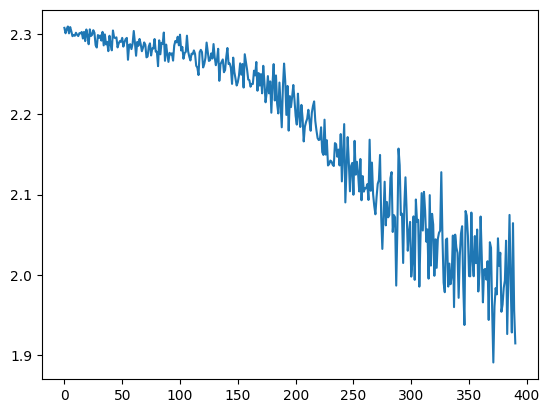

In [4]:
import numpy as np 

plt.plot(losses)
plt.show()

ZeroDivisionError: integer modulo by zero